In [1]:
import os
import sys

# === CẤU HÌNH ĐƯỜNG DẪN (SỬA LẠI CHO ĐÚNG VỚI KAGGLE CỦA BẠN) ===
# Ví dụ: /kaggle/input/vehicle-10-dataset/vehicle-10
DATA_DIR = "/kaggle/input/vehicle-10/vehicle-10" 

# File json chứa toàn bộ metadata (nếu bạn chưa chia split thì dùng file này để chia)
TRAIN_META_PATH = "/kaggle/input/vehicle-10/vehicle-10/train_meta.json"
TEST_META_PATH = "/kaggle/input/vehicle-10/vehicle-10/test_meta.json" # Hoặc valid_meta.json tùy tên bạn đặt

# Tạo các thư mục output (trong /kaggle/working)
WORK_DIR = "/kaggle/working"
FEATURES_DIR = os.path.join(WORK_DIR, "features")
MODELS_DIR = os.path.join(WORK_DIR, "models")
OUTPUT_DIR = os.path.join(WORK_DIR, "output")

os.makedirs(FEATURES_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Data Dir: {DATA_DIR}")
print(f"Working Dir: {WORK_DIR}")

Data Dir: /kaggle/input/vehicle-10/vehicle-10
Working Dir: /kaggle/working


In [2]:
%%writefile hog_method.py
import cv2
import numpy as np
from skimage.feature import hog
from skimage import io, color

class HOGExtractor:
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), 
                 cells_per_block=(2, 2), resize_shape=(128, 128)):
        """
        Initialize HOG feature extractor
        Args:
            orientations: Number of orientation bins
            pixels_per_cell: Size of a cell
            cells_per_block: Number of cells in each block
            resize_shape: Target size to resize images
        """
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.resize_shape = resize_shape
        
        # Calculate feature dimension
        # For 128x128 image with (8,8) cells and (2,2) blocks
        # cells: 16x16, blocks: 15x15, features: 15*15*2*2*9 = 8100
        cells_x = self.resize_shape[0] // self.pixels_per_cell[0]
        cells_y = self.resize_shape[1] // self.pixels_per_cell[1]
        blocks_x = cells_x - self.cells_per_block[0] + 1
        blocks_y = cells_y - self.cells_per_block[1] + 1
        self.feature_dim = (blocks_x * blocks_y * self.cells_per_block[0] * self.cells_per_block[1] * self.orientations)
        
        print(f"HOG extractor initialized with feature dimension: {self.feature_dim}")
    
    def extract_features(self, image_path):
        """
        Extract HOG features from an image
        Args:
            image_path: Path to the image file
        Returns:
            numpy array of HOG features
        """
        try:
            # Read image
            image = io.imread(image_path)
            
            # Convert to grayscale if needed
            if len(image.shape) == 3:
                image = color.rgb2gray(image)
            
            # Resize image
            image = cv2.resize(image, self.resize_shape)
            
            # Extract HOG features
            features = hog(image, 
                          orientations=self.orientations,
                          pixels_per_cell=self.pixels_per_cell,
                          cells_per_block=self.cells_per_block,
                          block_norm='L2-Hys',
                          visualize=False,
                          feature_vector=True)
            
            return features
        except Exception as e:
            print(f"Error extracting HOG features from {image_path}: {str(e)}")
            return None
    
    def get_feature_dim(self):
        """Return the dimensionality of extracted features"""
        return self.feature_dim

Overwriting hog_method.py


In [3]:
%%writefile svm.py
import os
import json
import numpy as np
import pickle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

class SVMClassifier:
    """
    SVM Classifier for vehicle classification using extracted features
    """
    
    def __init__(self, feature_method='clip', kernel='rbf', C=1.0, gamma='scale'):
        """
        Initialize SVM classifier
        """
        self.feature_method = feature_method.lower()
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        
        # Initialize SVM model
        # ADDED: class_weight='balanced' to handle class imbalance
        self.model = SVC(
            kernel=self.kernel,
            C=self.C,
            gamma=self.gamma,
            random_state=42,
            verbose=False,
            class_weight='balanced'
        )
        
        # Scaler for feature normalization
        self.scaler = StandardScaler()
        
        # Class names mapping
        self.class_names = None
        
        print(f"Initialized SVM Classifier")
        print(f"  Feature method: {self.feature_method}")
        print(f"  Kernel: {self.kernel}")
        print(f"  C: {self.C}")
        print(f"  Gamma: {self.gamma}")
    
    def load_features(self, features_path, metadata_path):
        """
        Load extracted features and labels
        """
        print(f"\nLoading features from {features_path}...")
        X = np.load(features_path)
        
        print(f"Loading metadata from {metadata_path}...")
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Map class names to indices
        class_name_to_idx = {
            'bicycle': 0, 'boat': 1, 'bus': 2, 'car': 3, 'helicopter': 4,
            'minibus': 5, 'motorcycle': 6, 'taxi': 7, 'train': 8, 'truck': 9
        }
        
        labels = metadata['labels']
        y_list = []
        
        for label in labels:
            if isinstance(label, str):
                y_list.append(class_name_to_idx.get(label.lower(), int(label) if label.isdigit() else 0))
            else:
                y_list.append(int(label))
        
        y = np.array(y_list, dtype=int)
        
        print(f"  Loaded {X.shape[0]} samples")
        print(f"  Feature dimension: {X.shape[1]}")
        print(f"  Number of classes: {len(np.unique(y))}")
        
        return X, y, metadata
    
    def train(self, X_train, y_train, normalize=True):
        """
        Train SVM model
        """
        print(f"\n{'='*60}")
        print(f"Training SVM Classifier")
        print(f"{'='*60}")
        
        print(f"Training samples: {X_train.shape[0]}")
        print(f"Feature dimension: {X_train.shape[1]}")
        print(f"Number of classes: {len(np.unique(y_train))}")
        
        if normalize:
            print("\nNormalizing features...")
            X_train = self.scaler.fit_transform(X_train)
        
        print("\nTraining SVM...")
        self.model.fit(X_train, y_train)
        
        y_train_pred = self.model.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)
        
        print(f"\n✓ Training completed!")
        print(f"Training accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
        
        return self
    
    def evaluate(self, X_test, y_test, normalize=True, class_names=None):
        """
        Evaluate SVM model on test set
        """
        print(f"\n{'='*60}")
        print(f"Evaluating SVM Classifier")
        print(f"{'='*60}")
        
        print(f"Test samples: {X_test.shape[0]}")
        
        if normalize:
            X_test = self.scaler.transform(X_test)
        
        print("\nMaking predictions...")
        y_pred = self.model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\n{'='*60}")
        print(f"RESULTS")
        print(f"{'='*60}")
        print(f"Test accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        print("\nClassification Report:")
        print("-" * 60)
        report = classification_report(
            y_test, 
            y_pred, 
            target_names=class_names,
            digits=4
        )
        print(report)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        print("\nConfusion Matrix:")
        print(conf_matrix)
        
        return accuracy, report, conf_matrix
    
    def grid_search_train(self, X_train, y_train, param_grid, normalize=True):
        """
        Thực hiện Grid Search để tìm tham số tối ưu
        """
        print(f"\n{'='*60}")
        print(f"BẮT ĐẦU GRID SEARCH (Tuning Hyperparameters)")
        print(f"{'='*60}")

        if normalize:
            print("Normalizing features...")
            X_train = self.scaler.fit_transform(X_train)
        
        # Grid Search with class_weight='balanced'
        grid_search = GridSearchCV(
            estimator=SVC(random_state=42, class_weight='balanced'),
            param_grid=param_grid,
            scoring='accuracy',
            cv=3, 
            verbose=2, 
            n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        
        self.model = grid_search.best_estimator_
        self.kernel = self.model.kernel
        self.C = self.model.C
        self.gamma = self.model.gamma
        
        print(f"\n✓ Grid Search hoàn tất!")
        print(f"Tham số TỐT NHẤT: {grid_search.best_params_}")
        print(f"Điểm TỐT NHẤT (Cross-Validation): {grid_search.best_score_:.4f}")
        
        return grid_search.best_score_, grid_search.best_params_

    def predict(self, X, normalize=True):
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if normalize:
            X = self.scaler.transform(X)
        predictions = self.model.predict(X)
        return predictions
    
    def save_model(self, save_path):
        model_data = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_method': self.feature_method,
            'kernel': self.kernel,
            'C': self.C,
            'gamma': self.gamma,
            'class_names': self.class_names
        }
        os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)
        with open(save_path, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"\n✓ Model saved to {save_path}")
    
    def load_model(self, model_path):
        print(f"Loading model from {model_path}...")
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
        self.model = model_data['model']
        self.scaler = model_data['scaler']
        self.feature_method = model_data['feature_method']
        self.kernel = model_data['kernel']
        self.C = model_data['C']
        self.gamma = model_data['gamma']
        self.class_names = model_data.get('class_names', None)
        print(f"✓ Model loaded successfully")

def train_svm_from_features(
    train_features_path,
    train_metadata_path,
    val_features_path,
    val_metadata_path,
    output_model_path,
    feature_method='clip',
    perform_grid_search=False,
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_names=None
):
    """
    Train SVM from extracted features
    """
    print(f"\n{'='*60}")
    print(f"SVM Training Pipeline")
    print(f"{'='*60}\n")
    
    # Initialize classifier
    classifier = SVMClassifier(
        feature_method=feature_method,
        kernel=kernel,
        C=C,
        gamma=gamma
    )
    
    # Load training data
    X_train, y_train, train_metadata = classifier.load_features(
        train_features_path,
        train_metadata_path
    )
    
    # Load validation data
    X_val, y_val, val_metadata = classifier.load_features(
        val_features_path,
        val_metadata_path
    )
    
    # Set class names if provided
    if class_names:
        classifier.class_names = class_names

    # GRID SEARCH PARAMETERS
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Thêm 100 để tìm C tốt nhất cho HOG
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.1, 0.01] # Thử thêm gamma số thực
    }
    
    if perform_grid_search:
        print(">> PERFORMING GRID SEARCH...")
        classifier.grid_search_train(X_train, y_train, param_grid, normalize=True)
    else:
        print(">> TRAINING WITH FIXED PARAMS...")
        classifier.train(X_train, y_train, normalize=True)
    
    # Evaluate on validation set
    classifier.evaluate(X_val, y_val, normalize=True, class_names=class_names)
    
    # Save model
    classifier.save_model(output_model_path)
    
    print(f"\n{'='*60}")
    print(f"Training completed!")
    print(f"{'='*60}\n")

Overwriting svm.py


In [4]:
import json
import random
import os
import numpy as np
from tqdm import tqdm
from hog_method import HOGExtractor

# 1. SPLIT DATASET (Tạo train/val split nếu cần)
def create_splits(meta_path):
    with open(meta_path, 'r') as f:
        data = json.load(f)
    
    paths, labels = data['path'], data['label']
    combined = list(zip(paths, labels))
    random.seed(42)
    random.shuffle(combined)
    
    # 80/20 Split
    split_idx = int(0.8 * len(combined))
    train_data = combined[:split_idx]
    val_data = combined[split_idx:]
    
    return train_data, val_data

# 2. EXTRACT FUNCTION (HOG ONLY)
def extract_hog_for_split(data_list, subset_name):
    print(f"\n--- Extracting HOG for {subset_name.upper()} set ---")
    
    extractor = HOGExtractor()
    features_list = []
    valid_paths = []
    valid_labels = []
    
    for img_rel_path, label in tqdm(data_list):
        full_path = os.path.join(DATA_DIR, img_rel_path)
        if os.path.exists(full_path):
            feat = extractor.extract_features(full_path)
            if feat is not None:
                features_list.append(feat)
                valid_paths.append(img_rel_path)
                valid_labels.append(label)
    
    if not features_list:
        print(f"Error: No features extracted for {subset_name}")
        return
        
    features_array = np.array(features_list)
    
    # Save .npy
    save_dir = os.path.join(FEATURES_DIR, 'hog', subset_name)
    os.makedirs(save_dir, exist_ok=True)
    
    np.save(os.path.join(save_dir, 'features_hog.npy'), features_array)
    
    # Save metadata
    meta = {
        'method': 'hog',
        'labels': valid_labels,
        'paths': valid_paths
    }
    with open(os.path.join(save_dir, 'features_hog_metadata.json'), 'w') as f:
        json.dump(meta, f)
        
    print(f"Saved {features_array.shape} to {save_dir}")

# RUN PIPELINE
print("Processing Data Split...")
train_list, val_list = create_splits(TRAIN_META_PATH)

print("Starting Feature Extraction (HOG)...")
extract_hog_for_split(train_list, 'train')
extract_hog_for_split(val_list, 'val')
print("\nExtraction Done!")

Processing Data Split...
Starting Feature Extraction (HOG)...

--- Extracting HOG for TRAIN set ---
HOG extractor initialized with feature dimension: 8100


 77%|███████▋  | 17777/23043 [13:48<03:34, 24.52it/s]

Error extracting HOG features from /kaggle/input/vehicle-10/vehicle-10/bus/Image_25.png: the input array must have size 3 along `channel_axis`, got (768, 1366, 4)


100%|██████████| 23043/23043 [18:13<00:00, 21.07it/s]


Saved (23042, 8100) to /kaggle/working/features/hog/train

--- Extracting HOG for VAL set ---
HOG extractor initialized with feature dimension: 8100


 47%|████▋     | 2707/5761 [01:33<01:47, 28.39it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 55%|█████▌    | 3186/5761 [01:51<01:28, 29.01it/s]

Error extracting HOG features from /kaggle/input/vehicle-10/vehicle-10/truck/Image_60.png: the input array must have size 3 along `channel_axis`, got (304, 438, 4)


 69%|██████▉   | 3964/5761 [02:22<00:51, 34.89it/s]

Error extracting HOG features from /kaggle/input/vehicle-10/vehicle-10/truck/Image_42.png: the input array must have size 3 along `channel_axis`, got (968, 2314, 4)


100%|██████████| 5761/5761 [03:45<00:00, 25.58it/s]


Saved (5759, 8100) to /kaggle/working/features/hog/val

Extraction Done!


In [5]:
import os
from svm import train_svm_from_features

# Base directories (Updated for Kaggle)
FEATURES_DIR_RUN = FEATURES_DIR # Defined in Cell 1
MODELS_DIR_RUN = MODELS_DIR     # Defined in Cell 1

CLASS_NAMES = [
    'bicycle', 'boat', 'bus', 'car', 'helicopter',
    'minibus', 'motorcycle', 'taxi', 'train', 'truck'
]

SVM_PARAMS = {
    'hog': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}
}

def train_hog_only():
    """Train SVM cho HOG với Grid Search"""
    
    # === QUAN TRỌNG: ĐÃ BẬT GRID SEARCH ===
    ENABLE_GRID_SEARCH = True
    current_grid_status = False 
    
    method = 'hog'
    
    print(f"\n\n{'='*80}")
    print(f"Training SVM for {method.upper()}")
    print(f"{'='*80}\n")
    
    try:
        train_features = os.path.join(FEATURES_DIR_RUN, method, 'train', f'features_{method}.npy')
        train_metadata = os.path.join(FEATURES_DIR_RUN, method, 'train', f'features_{method}_metadata.json')
        val_features = os.path.join(FEATURES_DIR_RUN, method, 'val', f'features_{method}.npy')
        val_metadata = os.path.join(FEATURES_DIR_RUN, method, 'val', f'features_{method}_metadata.json')
        output_model = os.path.join(MODELS_DIR_RUN, f'svm_{method}.pkl')
        
        # Train SVM
        params = SVM_PARAMS[method]
        
        train_svm_from_features(
            train_features_path=train_features,
            train_metadata_path=train_metadata,
            val_features_path=val_features,
            val_metadata_path=val_metadata,
            output_model_path=output_model,
            feature_method=method,
            kernel=params['kernel'],
            C=params['C'],
            gamma=params['gamma'],
            class_names=CLASS_NAMES,
            perform_grid_search=current_grid_status # Đã set True
        )
        
        print(f"\n✓ {method.upper()} training completed successfully!")
        
    except Exception as e:
        print(f"\n✗ Error training {method.upper()}: {str(e)}")
        raise e

# Run Training
train_hog_only()



Training SVM for HOG


SVM Training Pipeline

Initialized SVM Classifier
  Feature method: hog
  Kernel: rbf
  C: 1.0
  Gamma: scale

Loading features from /kaggle/working/features/hog/train/features_hog.npy...
Loading metadata from /kaggle/working/features/hog/train/features_hog_metadata.json...
  Loaded 23042 samples
  Feature dimension: 8100
  Number of classes: 10

Loading features from /kaggle/working/features/hog/val/features_hog.npy...
Loading metadata from /kaggle/working/features/hog/val/features_hog_metadata.json...
  Loaded 5759 samples
  Feature dimension: 8100
  Number of classes: 10
>> TRAINING WITH FIXED PARAMS...

Training SVM Classifier
Training samples: 23042
Feature dimension: 8100
Number of classes: 10

Normalizing features...

Training SVM...

✓ Training completed!
Training accuracy: 0.8972 (89.72%)

Evaluating SVM Classifier
Test samples: 5759

Making predictions...

RESULTS
Test accuracy: 0.6656 (66.56%)

Classification Report:
---------------------------------

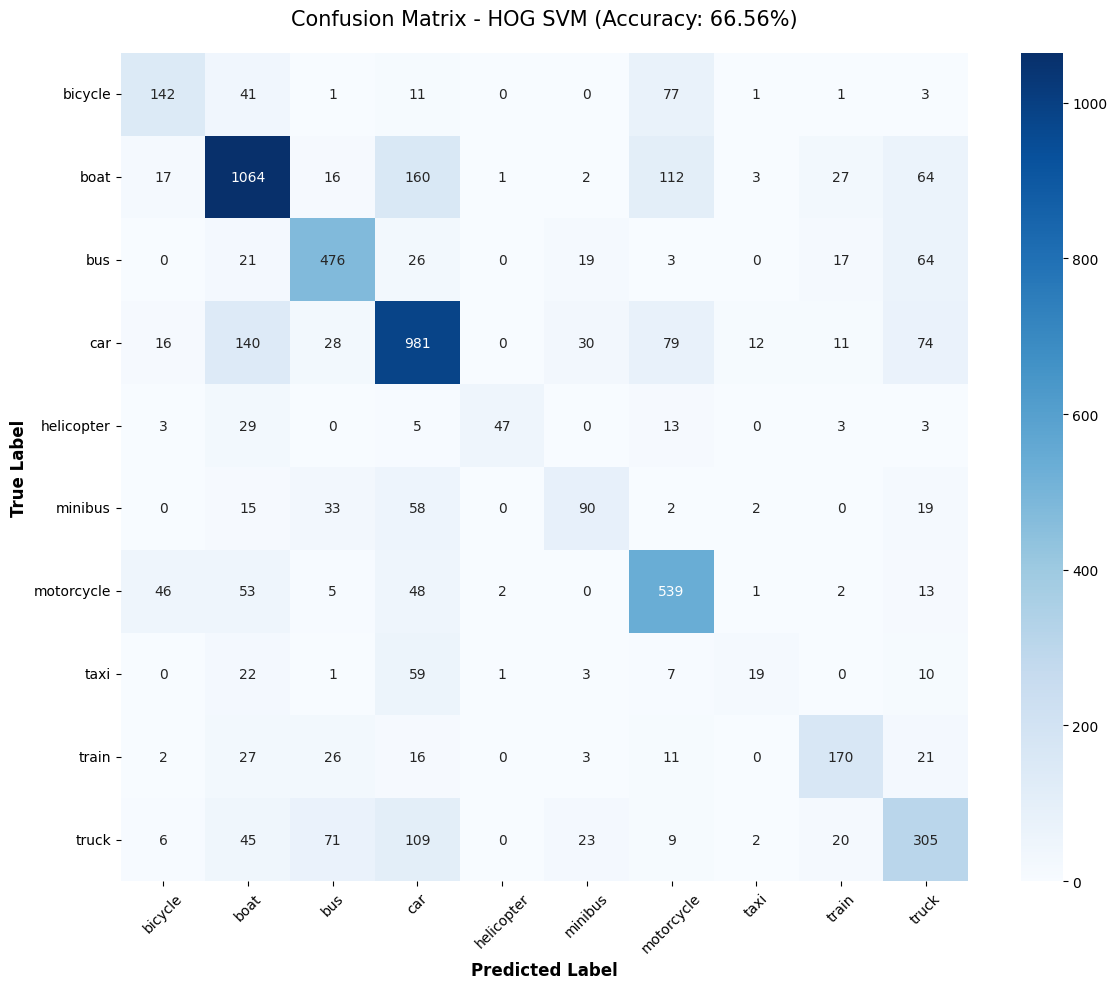

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cm = np.array([
 [ 142,   41,    1,   11,    0,    0,   77,    1,    1,    3],
 [  17, 1064,   16,  160,    1,    2,  112,    3,   27,   64],
 [   0,   21,  476,   26,    0,   19,    3,    0,   17,   64],
 [  16,  140,   28,  981,    0,   30,   79,   12,   11,   74],
 [   3,   29,    0,    5,   47,    0,   13,    0,    3,    3],
 [   0,   15,   33,   58,    0,   90,    2,    2,    0,   19],
 [  46,   53,    5,   48,    2,    0,  539,    1,    2,   13],
 [   0,   22,    1,   59,    1,    3,    7,   19,    0,   10],
 [   2,   27,   26,   16,    0,    3,   11,    0,  170,   21],
 [   6,   45,   71,  109,    0,   23,    9,    2,   20,  305]
])

classes = ['bicycle', 'boat', 'bus', 'car', 'helicopter',
           'minibus', 'motorcycle', 'taxi', 'train', 'truck']

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)

plt.title('Confusion Matrix - HOG SVM (Accuracy: 66.56%)', fontsize=15, pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()